# Convolutional autoencoder for image denoising

**Author:** [Santiago L. Valdarrama](https://twitter.com/svpino)<br>
**Date created:** 2021/03/01<br>
**Last modified:** 2021/03/01<br>
**Description:** How to train a deep convolutional autoencoder for image denoising.

## Introduction

This example demonstrates how to implement a deep convolutional autoencoder
for image denoising, mapping noisy digits images from the MNIST dataset to
clean digits images. This implementation is based on an original blog post
titled [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
by [François Chollet](https://twitter.com/fchollet).

## Setup

In [17]:
import numpy as np
import matplotlib.pyplot as plt

from keras import layers
from keras.datasets import mnist
from keras.models import Model


def preprocess(array):
    """Normalizes the supplied array and reshapes it."""
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


def noise(array):
    """Adds random noise to each image in the supplied array."""
    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """Displays ten random images from each array."""
    n = 10
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


## Prepare the data

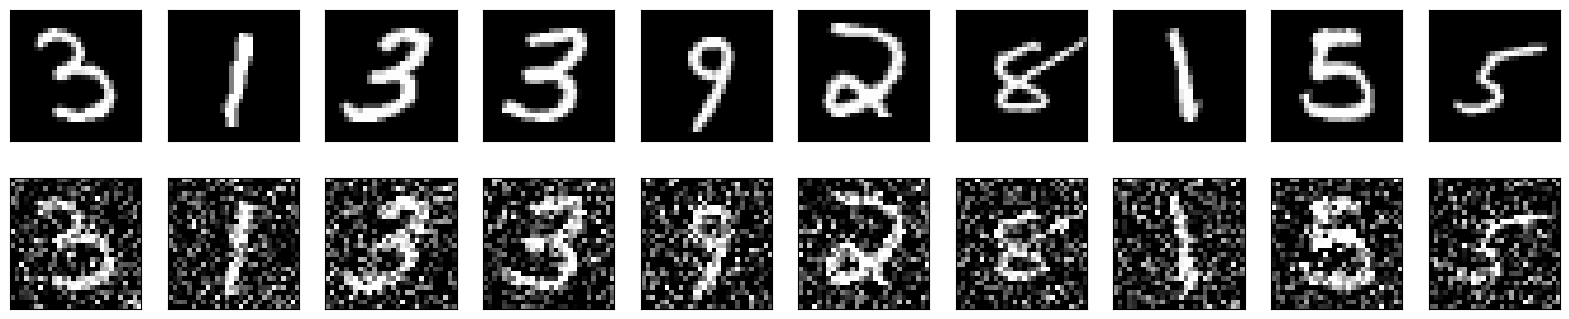

In [18]:
# Since we only need images from the dataset to encode and decode, we
# won't use the labels.
(train_data, _), (test_data, _) = mnist.load_data()

# Normalize and reshape the data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Create a copy of the data with added noise
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)

## Build the autoencoder

We are going to use the Functional API to build our convolutional autoencoder.

In [11]:
input = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,353 (110.75 KB)

 Trainable params: 28,353 (110.75 KB)

 Non-trainable params: 0 (0.00 B)

Now we can train our autoencoder using `train_data` as both our input data
and target. Notice we are setting up the validation data using the same
format.

In [ ]:
autoencoder.fit(
    x=train_data,
    y=train_data,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, test_data),
)

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.2582 - val_loss: 0.0734
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0729 - val_loss: 0.0698
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0699 - val_loss: 0.0684
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0688 - val_loss: 0.0675
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0679 - val_loss: 0.0669
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0672 - val_loss: 0.0664
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0667 - val_loss: 0.0660
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0664 - val_loss: 0.0656
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0660 - val_loss: 0.0654
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0656 - val_loss: 0.0651
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0654 - val_loss: 0.0649
Epoch 12/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/st

Let's predict on our test dataset and display the original image together with
the prediction from our autoencoder.

Notice how the predictions are pretty close to the original images, although
not quite the same.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


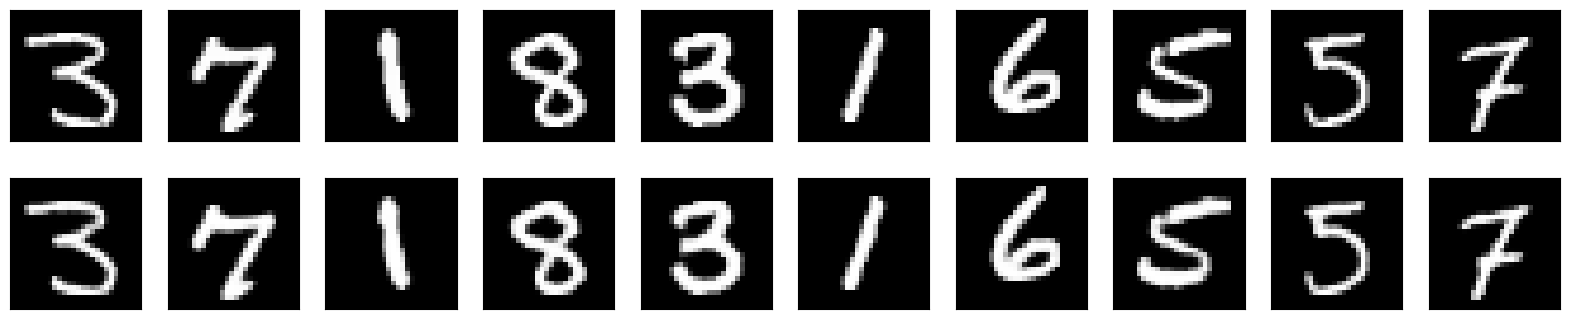

In [ ]:
predictions = autoencoder.predict(test_data)
display(test_data, predictions)

Now that we know that our autoencoder works, let's retrain it using the noisy
data as our input and the clean data as our target. We want our autoencoder to
learn how to denoise the images.

In [ ]:
autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=100,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)

Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1144 - val_loss: 0.0940
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0939 - val_loss: 0.0916
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0918 - val_loss: 0.0904
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0907 - val_loss: 0.0897
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0901 - val_loss: 0.0889
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0894 - val_loss: 0.0884
Epoch 7/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0888 - val_loss: 0.0879
Epoch 8/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0883 - val_loss: 0.0875
Epoch 9/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0882 - val_loss: 0.0873
Epoch 10/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0878 - val_loss: 0.0871
Epoch 11/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0875 - val_loss: 0.0869
Epoch 12/100
469/469 ━━━━━━━━━━━━━━━━━━━━

Let's now predict on the noisy data and display the results of our autoencoder.

Notice how the autoencoder does an amazing job at removing the noise from the
input images.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


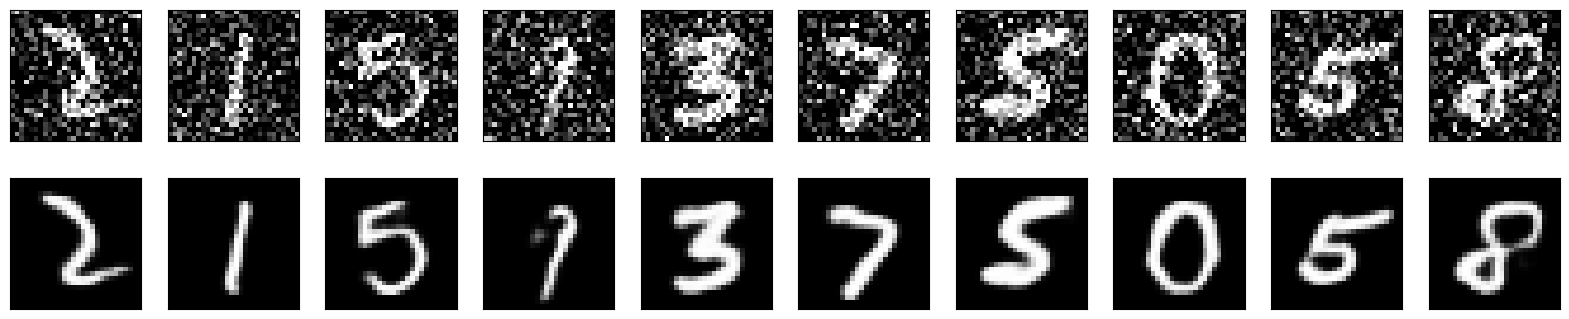

In [ ]:
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)

## De-blurring

In [22]:
import cv2

def blur(array):
    """Applies Gaussian blur to each image in the supplied array."""
    blur_factor = 5  # Adjust the kernel size for desired blur level
    blurred_array = np.zeros_like(array)  # Initialize blurred array

    for i in range(array.shape[0]):
        # Reshape the image to (28, 28) before applying blur
        image = array[i].reshape(28, 28)
        blurred_image = cv2.GaussianBlur(image, (blur_factor, blur_factor), 0)
        # Reshape the blurred image back to (28, 28, 1)
        blurred_array[i] = blurred_image.reshape(28, 28, 1)
    return blurred_array

Create a blurred version of the training and test data:

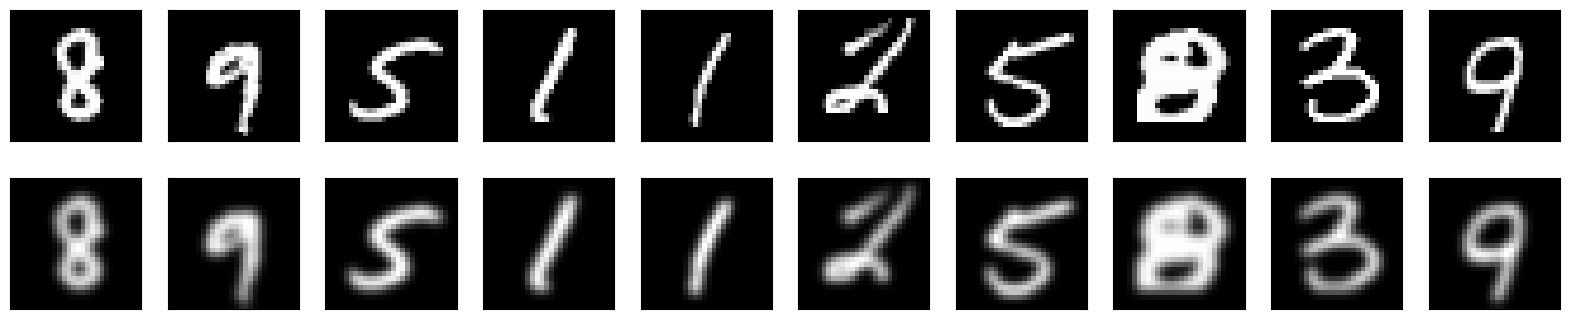

In [23]:
# Create a copy of the data with added Gaussion blur
blurred_train_data = blur(train_data)
blurred_test_data = blur(test_data)

# Display the train data and a version of it with added Gaussion blur
display(train_data, blurred_train_data)

 Let's retrain it using the blur data as our input and the clean data as our target. We want our autoencoder to learn how to deblur the images.

In [12]:
autoencoder.fit(
    x=blurred_train_data,
    y=train_data,
    epochs=100,
    batch_size=128,
    shuffle=True,
    validation_data=(blurred_test_data, test_data),
)

Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.2595 - val_loss: 0.0752
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0745 - val_loss: 0.0710
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0712 - val_loss: 0.0693
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0696 - val_loss: 0.0683
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0686 - val_loss: 0.0675
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0680 - val_loss: 0.0671
Epoch 7/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0675 - val_loss: 0.0666
Epoch 8/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0670 - val_loss: 0.0663
Epoch 9/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0667 - val_loss: 0.0661
Epoch 10/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0665 - val_loss: 0.0659
Epoch 11/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0662 - val_loss: 0.0657
Epoch 12/100
469/469 ━━━━━━━━━━━━━━━━━━

Let's now predict on the blur data and display the results of our autoencoder.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


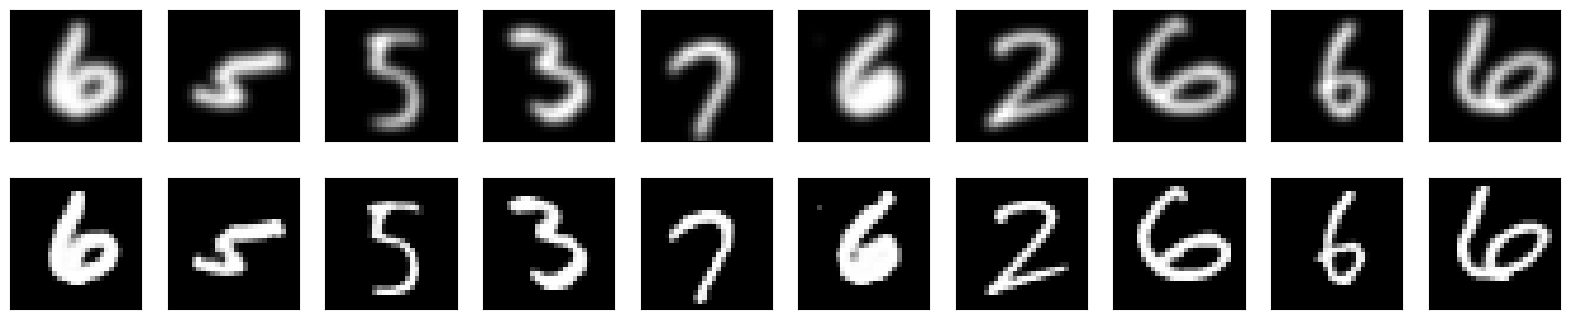

In [13]:
predictions = autoencoder.predict(blurred_test_data)
display(blurred_test_data, predictions)  # Visualize de-blurring results

## Improve the performance of the de-blurring model by myself.

In [ ]:
def blur(array):
    """Applies Gaussian blur to each image in the supplied array."""
    blur_factor = 5  # Adjust the kernel size for desired blur level
    blurred_array = np.zeros_like(array)  # Initialize blurred array

    for i in range(array.shape[0]):
        # Reshape the image to (28, 28) before applying blur
        image = array[i].reshape(28, 28)
        blurred_image = cv2.GaussianBlur(image, (blur_factor, blur_factor), 0)
        # Reshape the blurred image back to (28, 28, 1)
        blurred_array[i] = blurred_image.reshape(28, 28, 1)
    return blurred_array

### Use UpSampling2D for upsampling

In [21]:
input = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.UpSampling2D((2, 2))(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 14, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_4 (UpSampling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_5 (UpSampling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,857 (38.50 KB)

 Trainable params: 9,857 (38.50 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
autoencoder.fit(
    x=blurred_train_data,
    y=train_data,
    epochs=100,
    batch_size=128,
    shuffle=True,
    validation_data=(blurred_test_data, test_data),
)

Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.2486 - val_loss: 0.1062
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1048 - val_loss: 0.0997
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1002 - val_loss: 0.0979
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0984 - val_loss: 0.0967
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0973 - val_loss: 0.0957
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0964 - val_loss: 0.0950
Epoch 7/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0958 - val_loss: 0.0944
Epoch 8/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0950 - val_loss: 0.0938
Epoch 9/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0945 - val_loss: 0.0934
Epoch 10/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0941 - val_loss: 0.0931
Epoch 11/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0938 - val_loss: 0.0928
Epoch 12/100
469/469 ━━━━━━━━━━━━━━━━━━━━

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


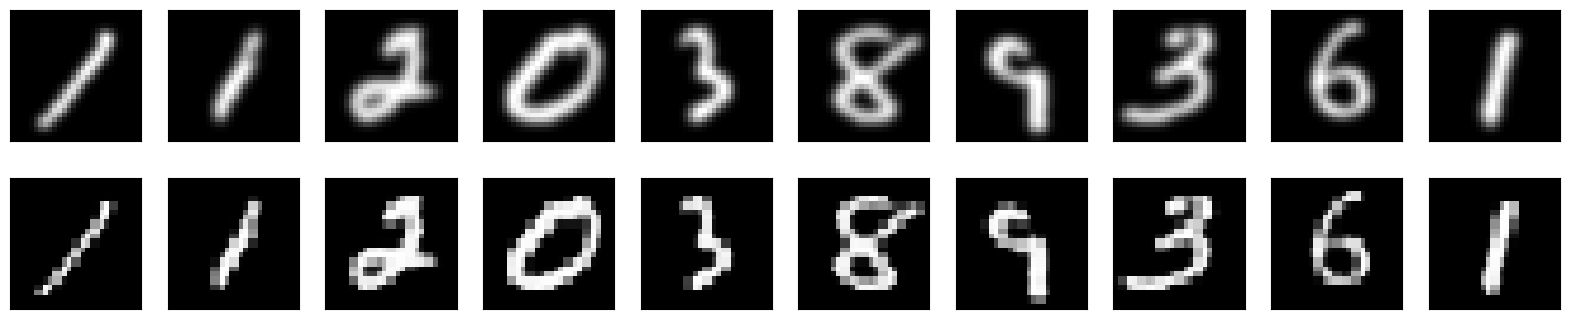

In [25]:
predictions = autoencoder.predict(blurred_test_data)
display(blurred_test_data, predictions)  # Visualize de-blurring results

### Use residual connections.

In [26]:
def residual_block(x):
       y = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
       y = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(y)
       return layers.add([x, y])

In [27]:
input = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = residual_block(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = residual_block(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = residual_block(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = residual_block(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 28, 28, 32)     │            320 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 28, 28, 32)     │          9,248 │ conv2d_13[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 28, 28, 32)     │          9,248 │ conv2d_14[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 28, 28, 32)     │              0 │ conv2d_13[0][0],       │
│                           │                        │                │ conv2d_15[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 14, 14, 32)     │              0 │ add[0][0]              │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 14, 14, 32)     │          9,248 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 14, 14, 32)     │          9,248 │ conv2d_16[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 14, 14, 32)     │          9,248 │ conv2d_17[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 14, 14, 32)     │              0 │ conv2d_16[0][0],       │
│                           │                        │                │ conv2d_18[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_11          │ (None, 7, 7, 32)       │              0 │ add_1[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_2        │ (None, 14, 14, 32)     │          9,248 │ max_pooling2d_11[0][0] │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 14, 14, 32)     │          9,248 │ conv2d_transpose_2[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 14, 14, 32)     │          9,248 │ conv2d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 14, 14, 32)     │              0 │ conv2d_transpose_2[0]… │
│                           │                        │                │ conv2d_20[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_3        │ (None, 28, 28, 32)     │          9,248 │ add_2[0][0]            │
│ (Conv2DTranspose)    

 Total params: 102,337 (399.75 KB)

 Trainable params: 102,337 (399.75 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
autoencoder.fit(
    x=blurred_train_data,
    y=train_data,
    epochs=100,
    batch_size=128,
    shuffle=True,
    validation_data=(blurred_test_data, test_data),
)

Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - loss: 0.1921 - val_loss: 0.0699
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 0.0693 - val_loss: 0.0664
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0667 - val_loss: 0.0651
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0654 - val_loss: 0.0644
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0649 - val_loss: 0.0642
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0641 - val_loss: 0.0635
Epoch 7/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0639 - val_loss: 0.0632
Epoch 8/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0636 - val_loss: 0.0627
Epoch 9/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0632 - val_loss: 0.0634
Epoch 10/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0631 - val_loss: 0.0626
Epoch 11/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0627 - val_loss: 0.0622
Epoch 12/100
469/469 ━━

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


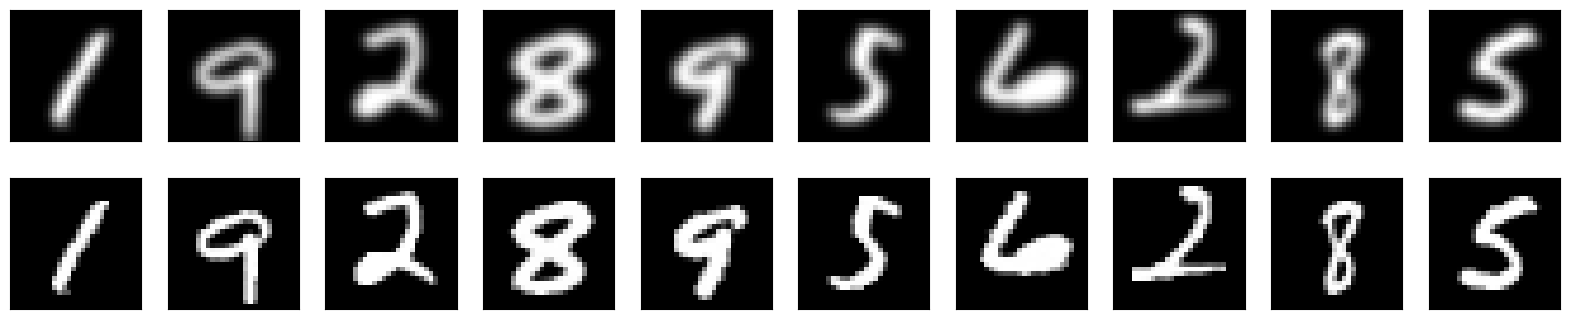

In [29]:
predictions = autoencoder.predict(blurred_test_data)
display(blurred_test_data, predictions)  # Visualize de-blurring results

### Adjust hyperparameter settings

In [34]:
from keras.optimizers import Adam

input = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
optimizer = Adam(learning_rate=0.00001)  # Modify the learning rate
autoencoder.compile(optimizer=optimizer, loss="binary_crossentropy")
autoencoder.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 14, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 14, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,353 (110.75 KB)

 Trainable params: 28,353 (110.75 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
autoencoder.fit(
       x=blurred_train_data,
       y=train_data,
       epochs=100,
       batch_size=64,  # Adjust batch size
       shuffle=True,
       validation_data=(blurred_test_data, test_data),
   )

Epoch 1/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.6786 - val_loss: 0.5771
Epoch 2/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.5240 - val_loss: 0.3404
Epoch 3/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.3007 - val_loss: 0.2309
Epoch 4/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.2171 - val_loss: 0.1871
Epoch 5/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1797 - val_loss: 0.1594
Epoch 6/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1530 - val_loss: 0.1320
Epoch 7/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1271 - val_loss: 0.1111
Epoch 8/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1095 - val_loss: 0.1027
Epoch 9/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.1026 - val_loss: 0.0980
Epoch 10/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0984 - val_loss: 0.0945
Epoch 11/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0948 - val_loss: 0.0915
Epoch 12/100
938/938 ━━━━━━━━━━━━━━━━━━━━

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


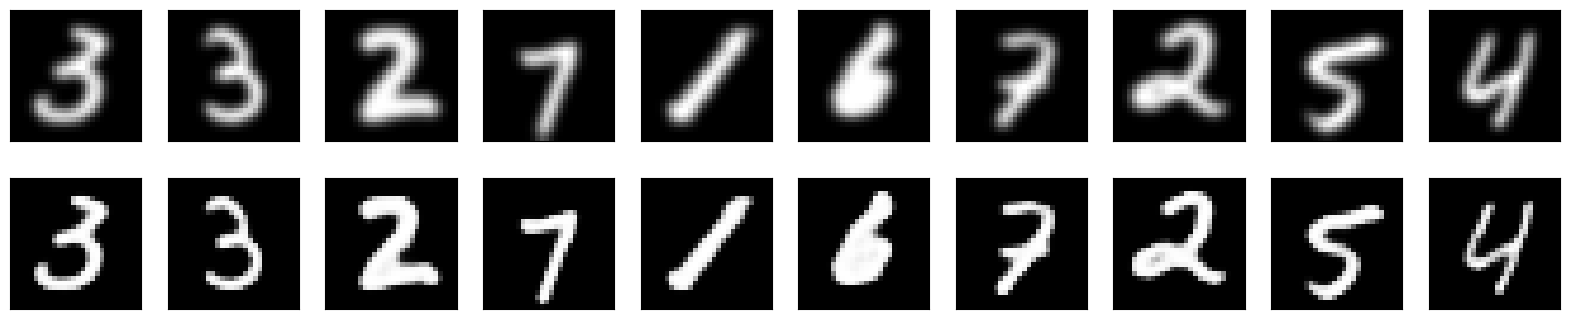

In [36]:
predictions = autoencoder.predict(blurred_test_data)
display(blurred_test_data, predictions)  # Visualize de-blurring results